In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

I m working on Human face emaotions dataset. Attempting to identify human emotions.

In [4]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [5]:
data_dir = '/kaggle/input/human-face-emotions/data'
classes = sorted(os.listdir(data_dir))
print(classes)


['Angry', 'Happy', 'Sad']


In [6]:
angry_faces = os.listdir(data_dir + '/Happy')
print(f'no. of angry faces images : {len(angry_faces)}')
print(angry_faces[0])


no. of angry faces images : 100
goup-happy-people-35582464.jpg


In [7]:
# converting images to tensors and resizing to 256 x 256 size.
work_ds = []
dataset = ImageFolder(data_dir, transform=ToTensor())

for img, label in dataset:
    img = transforms.Resize((256, 256))(img)
    work_ds.append((img, label))
work_ds[100][0].shape

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 256, 256])

In [8]:
def show_img_details(dataset, index):
    matplotlib.rcParams['figure.facecolor'] = '#ffffff'      # This line is important to display an image.
    print('Dataset size : ', dataset[index][0].shape)
    print(dataset[index])
    img, label = dataset[index]
    print(f"Label : {classes[label]}")
    plt.imshow(img.permute(1,2,0))

Dataset size :  torch.Size([3, 256, 256])
(tensor([[[0.8215, 0.9625, 0.9300,  ..., 0.9247, 0.8914, 0.9323],
         [0.9190, 0.9661, 0.9675,  ..., 0.9236, 0.8940, 0.9532],
         [0.8683, 0.8759, 0.7992,  ..., 0.9116, 0.9498, 0.8741],
         ...,
         [0.7850, 0.7944, 0.7796,  ..., 0.6461, 0.6702, 0.6344],
         [0.7964, 0.8123, 0.7991,  ..., 0.6417, 0.6334, 0.6255],
         [0.7886, 0.8089, 0.7752,  ..., 0.6290, 0.6196, 0.6235]],

        [[0.8332, 0.9743, 0.9418,  ..., 0.9443, 0.9110, 0.9519],
         [0.9308, 0.9778, 0.9792,  ..., 0.9432, 0.9136, 0.9728],
         [0.8800, 0.8877, 0.8110,  ..., 0.9312, 0.9694, 0.8937],
         ...,
         [0.5993, 0.6222, 0.6007,  ..., 0.6147, 0.6388, 0.6070],
         [0.6107, 0.6401, 0.6249,  ..., 0.6103, 0.6020, 0.5980],
         [0.6136, 0.6363, 0.6027,  ..., 0.6016, 0.5922, 0.5843]],

        [[0.8528, 0.9911, 0.9614,  ..., 0.9600, 0.9267, 0.9676],
         [0.9504, 0.9972, 0.9976,  ..., 0.9589, 0.9293, 0.9885],
         [0.899

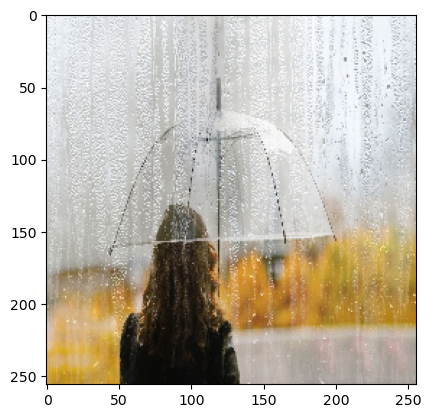

In [9]:
show_img_details(work_ds, 250)

Setting the hyper-parameters

In [49]:
num_epochs = 20
batch_size = 10
learning_rate = 0.0001

Splitting the work_ds into training, testing datasets

In [12]:

random_seed = 45
torch.manual_seed(random_seed)

test_size = 50
train_size = len(work_ds) - test_size
train_ds, test_ds = random_split(work_ds, [train_size, test_size])
print("Training dataset size : ", len(train_ds))
print("Testing dataset size : ", len(test_ds))

Training dataset size :  214
Testing dataset size :  50


In [13]:

train_dl = DataLoader(train_ds, batch_size = batch_size, 
                      shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size = batch_size,
                    shuffle=False, num_workers=2, pin_memory=True)

# choosing the device
device = 'cuda' if torch.cuda.is_available() == True else 'cpu'
print(device)


cuda


Designing the Convolution model (CNN):

Input image size = 3 x 256 x 256 <br>
         
After 1st round of 2 step convolution,       W_out = (W - F + 2P)/S + 1   <br>
        no. of kernels = 32      kernel size = 11       stride = 1      Padding = 1     <br>
        feature map size = 32 x 248 x 248     <br>
Again  <br>
        no. of kernels = 64      kernel size = 11       stride = 1      Padding = 1   <br>
        feature map size = 64 x 240 x 240   <br>
        
After 1st round of max pooling,             W_out = (W - F)/S + 1    <br>
        kernel size = 4          stride = 4    <br>
        feature map size = 64 x 60 x 60    <br>
        
        
After 2nd round of 2 step convolution,       W_out = (W - F + 2P)/S + 1     <br>
        no. of kernels = 128      kernel size = 11       stride = 1      Padding = 1    <br>
        feature map size = 128 x 52 x 52    <br>
Again   <br>
        no. of kernels = 128      kernel size = 11       stride = 1      Padding = 1    <br>
        feature map size = 128 x 44 x 44   <br>
        
After 1st round of max pooling,             W_out = (W - F)/S + 1    <br>
        kernel size = 2          stride = 2    <br>
        feature map size = 128 x 22 x 22       <br>
        
        
After 3rd round of 2 step convolution,       W_out = (W - F + 2P)/S + 1     <br>
        no. of kernels = 256      kernel size = 3       stride = 1      Padding = 1    <br>
        feature map size = 256 x 22 x 22      <br>
Again   <br>
        no. of kernels = 256      kernel size = 3       stride = 1      Padding = 1    <br>
        feature map size = 256 x 22 x 22     <br>
        
After 1st round of max pooling,             W_out = (W - F)/S + 1   <br>
        kernel size = 2          stride = 2    <br>
        feature map size = 256 x 11 x 11     <br>
        
Input to 1st fully connected layer,  <br>
    feature map size = (256 x 11 x 11, 1024)   <br>
    
Input to 2nd fully connected layer,  <br>
    feature map size = (1024, 256)   <br>
    
Input to 3rd fully connected layer,   <br>
    feature map size = (256, 3)   <br>

In [15]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, 
                               kernel_size=11, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=11, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, 
                               kernel_size=11, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, 
                               kernel_size=11, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, 
                               kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, 
                               kernel_size = 3, stride=1, padding=1)
        
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(256*11*11, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 3)
        
        
    
    def forward(self, x_in):
        # 1st convolution layer
        out = self.conv1(x_in)
        o = F.relu(out)
        o = self.conv2(o)
        o = F.relu(o)
        o = self.pool1(o)
        
        # 2nd convolution layer
        o = self.conv3(o)
        o = F.relu(o)
        o = self.conv4(o)
        o = F.relu(o)
        o = self.pool2(o)
        
        # 3rd convolution layer
        o = self.conv5(o)
        o = F.relu(o)
        o = self.conv6(o)
        o = F.relu(o)
        o = self.pool3(o)
        
        # applying fully connected layers
        o = o.view(-1, 256*11*11)
        o = self.fc1(o)
        o = F.relu(o)
        o = self.fc2(o)
        o = F.relu(o)
        out = self.fc3(o)
        
        return out
        

Training the CNN model

...Training started...
Epoch number : 1/20, Step : 9/22,loss : 1.0956077575683594
Epoch number : 1/20, Step : 19/22,loss : 1.0838485956192017
Epoch number : 2/20, Step : 9/22,loss : 1.1122231483459473
Epoch number : 2/20, Step : 19/22,loss : 1.113963007926941
Epoch number : 3/20, Step : 9/22,loss : 1.1334493160247803
Epoch number : 3/20, Step : 19/22,loss : 1.1115895509719849
Epoch number : 4/20, Step : 9/22,loss : 1.0955790281295776
Epoch number : 4/20, Step : 19/22,loss : 1.111138939857483
Epoch number : 5/20, Step : 9/22,loss : 1.09926176071167
Epoch number : 5/20, Step : 19/22,loss : 1.0975919961929321
Epoch number : 6/20, Step : 9/22,loss : 1.0894099473953247
Epoch number : 6/20, Step : 19/22,loss : 1.0871636867523193
Epoch number : 7/20, Step : 9/22,loss : 1.1019243001937866
Epoch number : 7/20, Step : 19/22,loss : 1.100896954536438
Epoch number : 8/20, Step : 9/22,loss : 1.1003531217575073
Epoch number : 8/20, Step : 19/22,loss : 1.0960657596588135
Epoch number : 9/20, Step : 9/

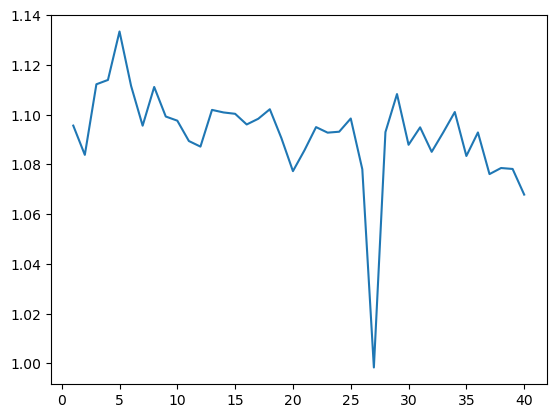

In [50]:
x = []
y = []
s_p = 0
t_steps = len(train_dl)

model = ConvNet().to(device)
cost_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print('...Training started...')
for epoch in range(num_epochs):
    for idx,(image, label) in enumerate(train_dl):
        image = image.to(device)
        label = label.to(device)
        model.train()
        
        # forward propagation
        pred = model(image)
        loss = cost_f(pred, label)
        
        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # capturing the loss
        if((idx+1) % 10 == 0):
            s_p += 1
            print(f"Epoch number : {epoch+1}/{num_epochs}, Step : {idx}/{t_steps},loss : {loss}", sep='\t')
            y.append(loss.item())
            x.append((s_p))
    
print("Training complete... Displaying the results...")
plt.plot(x, y)
xlabel = 'no. of steps/epoch'
ylabel = 'cost function'

print("...Saving the model...")
FILE = 'trained_model.pth'
data = {
    'model_state' : model.state_dict(),
    'batch_size' : batch_size,
    'num_epochs' : num_epochs,
    'learning_rate' : learning_rate
}
torch.save(data, FILE)
print(f"File saved to {FILE}.")

Testing the model accuracy

In [ ]:
img, label =next(iter(test_dl))
g = torch.max(torch.softmax(model(img), dim=1), 1)[1]
print(label == g)
(label==g).sum()

In [51]:
# loading the trained model
FILE = '/kaggle/working/trained_model.pth'
data = torch.load(FILE)

num_epochs = data['num_epochs']
batch_size = data['batch_size']
l_r = data['learning_rate']
model = ConvNet().to(device)
model.load_state_dict(data['model_state'])

n_samples = 0
n_correct = 0

print('...calculating accuracy...')
for epoch in range(num_epochs):
    for img, label in test_dl:
        img = img.to(device)
        label = label.to(device)
        model.eval()
        
        # make prediction
        predict = torch.max(torch.softmax(model(img), dim=1), 1)[1]
        n_correct += (predict == label).sum().item()
        n_samples += len(label)
        
# calculating accuracy
acc = n_correct/n_samples
print(f"Model accuracy = {acc*100} %")

...calculating accuracy...
Model accuracy = 48.0 %


In [52]:

# using the model
def use_model(img_loc):
    im = plt.imread(im_dir)
    plt.imshow(im)
    t = transforms.ToTensor()(im)
    t = transforms.Resize((256, 256))(t)
    t = t.to(device)
    pred = torch.max(torch.softmax(model(t), dim=1), 1)[1]
    return pred.item()


Label : Happy


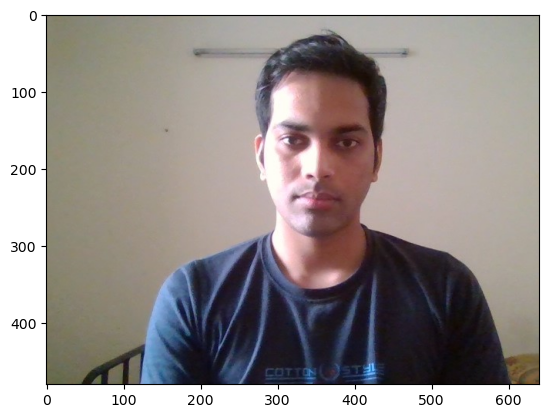

In [53]:
im_dir = '/kaggle/input/my-test/WIN_20211021_12_12_28_Pro.jpg'
print(f"Label : {classes[use_model(im_dir)]}")


Resources :

 1 - https://www.tutorialspoint.com/pytorch-how-to-resize-an-image-to-a-given-size
 
 2 - https://jovian.com/aakashns/05-cifar10-cnn